In [229]:
#import data from sources
import pandas as pd
from functools import reduce
import requests 
import os
import pathlib
from datetime import datetime
import matplotlib.pyplot as plt
from numpy import random
from tabulate import tabulate
import math

# Step 1 : Gather Data
- Call EIA.gov API
    - Set the api key 
    - Set the start and end month in 'YYYYMM' format

- Average Consumption Dataset :
    - Retail sales of electricity, Florida, residential, monthly
    - Units in Million Kilowatthours
    - Conversion to kWh : X_kWh = (X * 10^6)

- Average Prosumer Generation Dataset :
    - Net generation, small-scale solar photovoltaic, Florida , residential, monthly
    - Units in thousand megawatthours
    - Conversion to kWh : X_kWh = (X * 10^3 * 10^3)
    
- Average  Price Dataset:
    - Average retail price of electricity, Florida, monthly
    - Units in cents per Kilowatthour
    - Conversion to cents/kWh : X_cents/kWh = X_cents/kWh


<AxesSubplot:title={'center':'FL. Residential Ensemble Dataset'}, xlabel='time'>

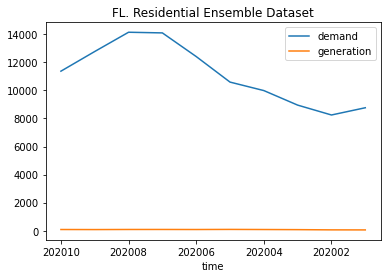

In [231]:
# Data Gathering Settings
api_key='d42ebe76b736d7815489e3298ff17079'
start ='202001'
end = '202012'
eia_url = 'http://api.eia.gov/series/'

# Series
eia_fpl_series = [
    {
        'type':'demand',
        'series':'ELEC.SALES.FL-RES.M'
    },
    {
        'type':'generation',
        'series':'ELEC.GEN.DPV-FL-8.M'
    },
    {
        'type':'price',
        'series':'ELEC.PRICE.FL-RES.M'
    }
    #'EBA.FLA-ALL.D.H',
    #'solar_gen':'EBA.FLA-ALL.NG.SUN.H',
]

datasets = []
for entry in eia_fpl_series:
    series = entry['series']
    url = f'{eia_url}?api_key={api_key}&series_id={series}&start={start}&end={end}'
    data = requests.get(url).json()['series'][0]['data']
    df = pd.DataFrame(data,columns=['time',entry['type']])
    datasets.append(df)

# merge the datasets
df = reduce(lambda  left,right: pd.merge(left,right,on=['time'],how='outer'), datasets)
#plot the data
df.plot(x='time',y=['demand','generation'],title="FL. Residential Ensemble Dataset")

# Step 2 : Wrangle Data
- Apply unit conversions to the raw datasets so that it is all in kilowatt-hours
- Normalize the ensemble dataset of all of florida to create a normalized curve
- Append the time and price datasets accordingly to the modified generation and demand datasets

     time    demand  generation  price
9  202001  0.619526    0.608698  11.73
8  202002  0.583059    0.650020  11.76
7  202003  0.632822    0.823069  11.64
6  202004  0.706091    0.915735  11.71
5  202005  0.748825    1.000000   9.84
4  202006  0.877596    0.918344  11.53
3  202007  0.996674    0.958952  11.71
2  202008  1.000000    0.947582  11.61
1  202009  0.902985    0.873409  11.97
0  202010  0.803816    0.924304  11.49


<AxesSubplot:title={'center':'FL. Residential Normalized Dataset'}, xlabel='time'>

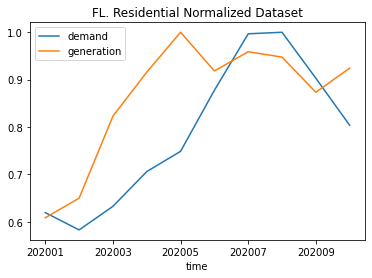

In [233]:

# apply conversion of units
df['demand'] = df['demand'].apply(lambda x: x*pow(10,6))
df['generation'] = df['generation'].apply(lambda x: x*pow(10,6))

#print(df)

# normalize into percentages 
df['demand'] = df['demand'].apply(lambda x: x/df['demand'].max())
df['generation'] = df['generation'].apply(lambda x: x/df['generation'].max())
df= df.sort_values(by=['time'])

print(df)

#plot the data
df.plot(x='time',y=['demand','generation'],title="FL. Residential Normalized Dataset")

# Step 3 : Create Statistical Model from Datasets
## Synthesizing Individual Prosumer data from an Ensemble Datasets

> Typical individual consumption per month in florida : 1100kWh/mo.

The datasets collected are monthly averages rolled up for the entire state of florida. 
The florida data can be used as a baseline to show variations each month from a norm.
The average consumer demand in florida was estimated to be 1100kWh a month. Since we have a percentage of the average home usage we can use it as our baseline deviation from norm. 

> Typical individual solar generation per month in florida : (10kW) * 4hr*30days = 1200kWh/mo.

Most florida prosumers are using residential PV installations that are considered Tier 1, less than 10kW AC capacity. By multiplying the possible generation accross the hours of optimum daylight each day (assumption made from surveys) (4 hours * ~30days) we can arrive at an approximate normal capacity for a typical home at around 1200kWh a month. The florida regulations for net metering prohibits the generation of more than 115% of the homes consumption. This limitation fits the benchmarks chosen for an everage prosumers generation, in this case (1,125kWh/mo.).


In [235]:
# Generate a collection of prosumers
N = 3 # Number of prosumers to create

# set some constants for the build
init = [
        {
            'type':'generation',
            'mean':1200,
            'std': 1200 * 0.2, #20% of mean,
            'ulim':1200, # upper limit (capacity),
            'llim':0 # lower limit 
        },
        {   
            'type':'demand',
            'mean':1100,
            'std': 1100 * 0.2, #20% of mean
            'ulim':1100 * 2, # upper limit (max load),
            'llim':1100 * 0.1 # lower limit (constant load) 
        } 
    ]

## Generate statistical instances of prosumer models
- Create N prosumers
- Create a normally distributed generation and demand curve given the initial parameters for mean, standard deviation, upper and lower bounds.
- Apply a gaussian random distribution with mean and standard deviation for each point in the original datasets for the gen and demand curve. 
- Create net energy by subtracting the gen and demand values and limiting it to be positive
- Create a net metering profit by paying for the net energy at each sample interval

In [237]:
def get_net_meter_payment(price,net_energy):
    # convert to dollars from cents
    return net_energy*(0.01*price)


In [239]:
prosumers = []
for n in range(N):
    pro_datasets = []
    # Create a price column
    pro_datasets.append(df[['time','price']])
    # Create the generation and demand columns    
    for conf in init:
        curve = df[conf['type']]
        c = [max(conf['llim'],min(conf['ulim'],
        random.normal(loc=conf['mean'],scale=conf['std'])*x)) for x in curve]
        df_t = pd.DataFrame(list(zip(df['time'],c)),columns=['time',conf['type']])
        pro_datasets.append(df_t)
     # merge the datasets
    df_p = reduce(lambda  left,right: pd.merge(left,right,on=['time'],how='outer'), pro_datasets)

    # Add net energy from demand and generation cols
    net_energy = df_p['demand'] - df_p['generation']
    net_energy_cap = [max(x,0) for x in net_energy]
    time_n_net_energy = list(zip(df['time'],net_energy_cap))
    df_net = pd.DataFrame(time_n_net_energy,columns=['time','net_energy'])
    df_pn = df_p.merge(df_net,on='time')

    # Create the net metering profit from net energy
    net_meter = get_net_meter_payment(net_energy=df_pn['net_energy'],price=df_pn['price'])
    time_n_net_meter = list(zip(df['time'],net_meter))
    df_net_met = pd.DataFrame(time_n_net_meter,columns=['time','net_meter'])
    df_m = df_pn.merge(df_net_met,on='time')

    # add prosumer to group
    prosumers.append({"id":n+1,"data":df_m})

In [241]:

def get_nrg_xchange_payment(price,net_energy,total_net_energy):
    a = 10000000
    n=1
    tx = total_net_energy
    payments = []
    for i in range(len(net_energy)):
        x = net_energy[i]
        q = (0.01*price[i])
        try:
            ans = pow(x,n)*q/math.exp(pow(tx,2)/a)
        except OverflowError:
            ans = float('inf')
        payments.append(ans)
    return payments

# Create the net metering profit from net energy    
total_net_energy = sum([p['data']['net_energy'].sum() for p in prosumers])
for prosumer in prosumers:
    df_prosumer = prosumer['data']    
    nrg = get_nrg_xchange_payment(net_energy=df_prosumer['net_energy'],price=df_prosumer['price'],total_net_energy=total_net_energy)
    time_n_nrg = list(zip(df_prosumer['time'],nrg))
    df_nrg = pd.DataFrame(time_n_nrg,columns=['time','nrg_meter'])
    prosumer['data'] = df_prosumer.merge(df_nrg,on='time')



Prosumer:1
|   time |   price |   generation |   demand |   net_energy |   net_meter |   nrg_meter |
|--------|---------|--------------|----------|--------------|-------------|-------------|
| 202001 |   11.73 |     1050.18  |  494.962 |       0      |     0       |     0       |
| 202002 |   11.76 |      597.439 |  635.672 |      38.2328 |     4.49618 |     4.27305 |
| 202003 |   11.64 |      981.825 |  650.731 |       0      |     0       |     0       |
| 202004 |   11.71 |     1163.45  | 1093.82  |       0      |     0       |     0       |
| 202005 |    9.84 |     1142.19  |  832.981 |       0      |     0       |     0       |
| 202006 |   11.53 |     1200     |  917.776 |       0      |     0       |     0       |
| 202007 |   11.71 |     1200     | 1342.23  |     142.231  |    16.6553  |    15.8287  |
| 202008 |   11.61 |     1200     |  775.525 |       0      |     0       |     0       |
| 202009 |   11.97 |     1200     | 1098.25  |       0      |     0       |     0       

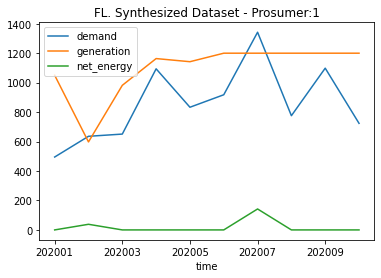

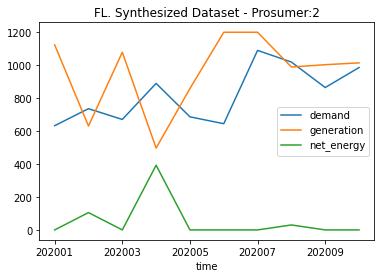

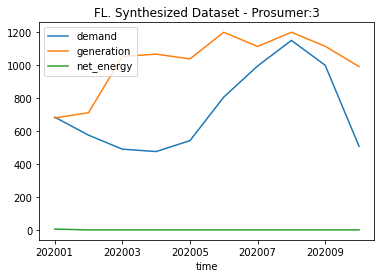

In [243]:
#plot the prosumers
for prosumer in prosumers:
    print(f"\nProsumer:{prosumer['id']}")
    print(tabulate(prosumer['data'], headers = 'keys', tablefmt = 'github',showindex=False))
    prosumer['data'].plot(x='time',y=['demand','generation','net_energy'],title=f"FL. Synthesized Dataset - Prosumer:{prosumer['id']}")
    

# Step 4 : Analyze Results for Net-Metering Profit

Determine the results of the prosumers 

|   Prosumer |   Total Profit ($) |   Total NRG X-Change Profit ($) |   Total Net Energy (kWh) |
|------------|--------------------|---------------------------------|--------------------------|
|          1 |          21.1515   |                       20.1018   |                180.464   |
|          2 |          61.8483   |                       58.779    |                527.975   |
|          3 |           0.587082 |                        0.557947 |                  5.00496 |


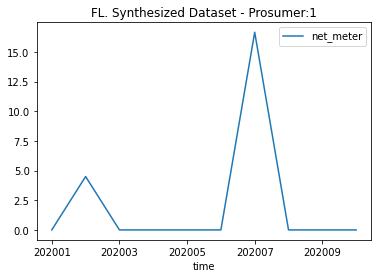

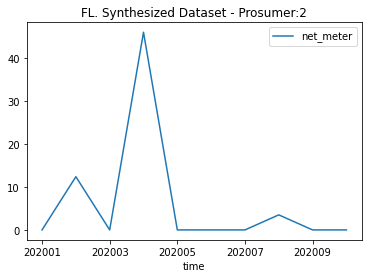

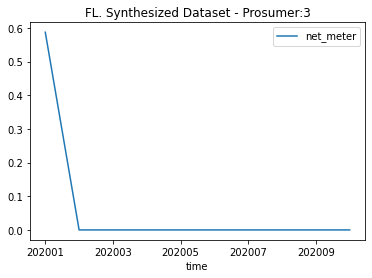

In [245]:
sheet = []
for prosumer in prosumers:
    total_profit = prosumer['data']['net_meter'].sum()
    total_net_energy= prosumer['data']['net_energy'].sum()
    total_nrg_profit = prosumer['data']['nrg_meter'].sum()
    sheet.append({'Prosumer':prosumer['id'],'Total Profit ($)':total_profit,'Total NRG X-Change Profit ($)':total_nrg_profit,'Total Net Energy (kWh)':total_net_energy})
    prosumer['data'].plot(x='time',y=['net_meter'],title=f"FL. Synthesized Dataset - Prosumer:{prosumer['id']}")

print(tabulate(sheet, headers = 'keys', tablefmt = 'github',showindex=False))    

In [246]:
# install 